<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/example_notebooks/3_mxrcnn/Example%20-%20person%20detection%20in%20infrared%20images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/3_mxrcnn/installation
     
 - Select the right requirements file and run
 
     - cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# Download Dataset

- credits: https://camel.ece.gatech.edu/

In [6]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LSBBmntmLAloPO5Cc3ar61ranfBx8D8W' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LSBBmntmLAloPO5Cc3ar61ranfBx8D8W" -O ir_dataset.zip && rm -rf /tmp/cookies.txt

In [ ]:
! unzip ir_dataset.zip

# Desired annotation - COCO Format

## Dataset Directory Structure

    ./ (root_dir)
          |
          |------openlogo (coco_dir) 
          |         |
          |         |---JPEGImages (img_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations (anno_dir)
          |         |----|
          |              |--------------------instances_Images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

# Annotation Conversion - Monk format to COCO

In [1]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [2]:
# Provide details on directory in Monk Format

In [3]:
root = "ir_dataset";
img_dir = "images/";
anno_file = "train_labels.csv";

In [4]:
# Need not change anything below

In [5]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [6]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [7]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [8]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [9]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [10]:
delimiter = " ";

In [11]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 1/1 [00:00<00:00, 5599.87it/s]


In [12]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 4703/4703 [00:04<00:00, 1085.19it/s]


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
# Dataset params

In [4]:
root_dir = "./";
coco_dir = "ir_dataset";
img_dir = "images"; 

In [5]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [6]:
# Model Type

In [7]:
set_model_params(model_name="vgg16");

In [8]:
# Hyper Params

In [9]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=2, batch_size=2);

In [10]:
set_output_params(log_interval=100, save_prefix="model_vgg16");

In [11]:
# Preprocessing params

In [12]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [13]:
# Initialize params

In [14]:
initialize_rpn_params();

In [15]:
initialize_rcnn_params();

In [16]:
# Remove caches if any

In [17]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [18]:
# Invoke Dataloader

In [19]:
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_images_roidb.pkl


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


INFO:root:saving cache ./cache/coco_images_roidb.pkl
INFO:root:coco_images num_images 4703
INFO:root:filter roidb: 4703 -> 4703
INFO:root:coco_images append flipped images to roidb


In [20]:
#Network

In [21]:
sym = set_network();

In [22]:
# Train

In [23]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (2, 36, 62, 62),
 'bbox_weight': (2, 36, 62, 62),
 'data': (2, 3, 1000, 1000),
 'gt_boxes': (2, 100, 5),
 'im_info': (2, 3),
 'label': (2, 1, 558, 62)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (2, 64, 8),
 'blockgrad0_output': (2, 64),
 'cls_prob_reshape_output': (2, 64, 2),
 'rpn_bbox_loss_output': (2, 36, 62, 62),
 'rpn_cls_prob_output': (2, 2, 558, 62)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [1] lr_iters [4703]
INFO:root:Epoch[0] Batch [0-100]	Speed: 7.07 samples/sec	RPNAcc=0.969543	RPNLogLoss=0.104563	RPNL1Loss=0.567828	RCNNAcc=0.965501	RCNNLogLoss=0.

INFO:root:Epoch[0] Batch [0-4400]	Speed: 1.95 samples/sec	RPNAcc=0.992893	RPNLogLoss=0.022590	RPNL1Loss=0.219817	RCNNAcc=0.960554	RCNNLogLoss=0.092774	RCNNL1Loss=1.082283
INFO:root:Epoch[0] Batch [0-4500]	Speed: 3.18 samples/sec	RPNAcc=0.992956	RPNLogLoss=0.022523	RPNL1Loss=0.217855	RCNNAcc=0.960396	RCNNLogLoss=0.093393	RCNNL1Loss=1.074359
INFO:root:Epoch[0] Batch [0-4600]	Speed: 5.46 samples/sec	RPNAcc=0.993019	RPNLogLoss=0.022316	RPNL1Loss=0.216844	RCNNAcc=0.960949	RCNNLogLoss=0.092223	RCNNL1Loss=1.061016
INFO:root:Epoch[0] Batch [0-4700]	Speed: 5.13 samples/sec	RPNAcc=0.993150	RPNLogLoss=0.021951	RPNL1Loss=0.215751	RCNNAcc=0.961371	RCNNLogLoss=0.091356	RCNNL1Loss=1.045654
INFO:root:Epoch[0] Train-RPNAcc=0.993153
INFO:root:Epoch[0] Train-RPNLogLoss=0.021942
INFO:root:Epoch[0] Train-RPNL1Loss=0.215724
INFO:root:Epoch[0] Train-RCNNAcc=0.961386
INFO:root:Epoch[0] Train-RCNNLogLoss=0.091327
INFO:root:Epoch[0] Train-RCNNL1Loss=1.045292
INFO:root:Epoch[0] Time cost=2418.943
INFO:root:Saved

INFO:root:Epoch[1] Batch [0-4300]	Speed: 1.87 samples/sec	RPNAcc=0.994854	RPNLogLoss=0.014905	RPNL1Loss=0.195132	RCNNAcc=0.967911	RCNNLogLoss=0.078461	RCNNL1Loss=0.902444
INFO:root:Epoch[1] Batch [0-4400]	Speed: 1.93 samples/sec	RPNAcc=0.994803	RPNLogLoss=0.015080	RPNL1Loss=0.190062	RCNNAcc=0.967151	RCNNLogLoss=0.080164	RCNNL1Loss=0.904041
INFO:root:Epoch[1] Batch [0-4500]	Speed: 3.15 samples/sec	RPNAcc=0.994848	RPNLogLoss=0.015074	RPNL1Loss=0.188087	RCNNAcc=0.966929	RCNNLogLoss=0.080925	RCNNL1Loss=0.897564
INFO:root:Epoch[1] Batch [0-4600]	Speed: 5.45 samples/sec	RPNAcc=0.994892	RPNLogLoss=0.014950	RPNL1Loss=0.187108	RCNNAcc=0.967337	RCNNLogLoss=0.080052	RCNNL1Loss=0.888299
INFO:root:Epoch[1] Batch [0-4700]	Speed: 5.12 samples/sec	RPNAcc=0.994980	RPNLogLoss=0.014725	RPNL1Loss=0.186181	RCNNAcc=0.967617	RCNNLogLoss=0.079511	RCNNL1Loss=0.876933
INFO:root:Epoch[1] Train-RPNAcc=0.994982
INFO:root:Epoch[1] Train-RPNLogLoss=0.014720
INFO:root:Epoch[1] Train-RPNL1Loss=0.186177
INFO:root:Epoch

# Running Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./ir_dataset/annotations/classes.txt");

In [4]:
#Model - Select the model as per number of iterations it has been trained for

In [5]:
set_model_params(model_name="vgg16", model_path="trained_model/model_vgg16-0002.params");

In [6]:
#Hyper Params

In [6]:
set_hyper_params(gpus="0", batch_size=1);

In [8]:
# Preprocessing

In [7]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [8]:
#Initalization

In [9]:
initialize_rpn_params();

In [10]:
initialize_rcnn_params();

In [11]:
#Network

In [12]:
sym = set_network();
mod = load_model(sym);

In [13]:
#Load Image and infer

person
 0.9942793846130371 [140.07286458333334, 99.70341796875, 161.80848958333334, 150.84588541666668]
['person\n', 0.9942793846130371, [140.07286458333334, 99.70341796875, 161.80848958333334, 150.84588541666668]]


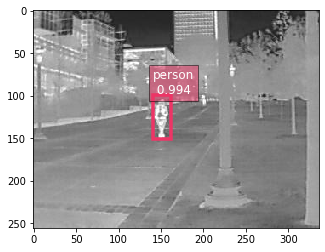

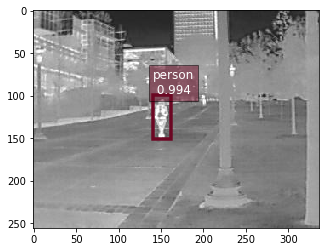

In [17]:
set_output_params(vis_thresh=0.9, vis=True)
output = Infer("Monk_Object_Detection/example_notebooks/sample_dataset/ir_dataset_test/1.jpg", mod);

person
 0.9891431927680969 [119.04485677083333, 98.44919270833333, 140.2752734375, 136.47752604166666]
person
 0.9074171781539917 [174.15869791666665, 101.44493489583333, 195.16669270833333, 137.69368489583334]
['person\n', 0.9891431927680969, [119.04485677083333, 98.44919270833333, 140.2752734375, 136.47752604166666]]


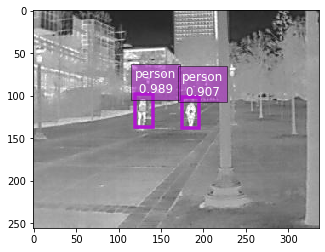

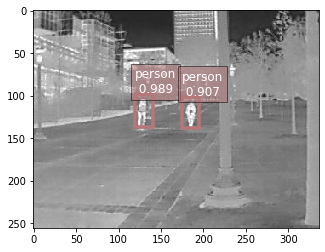

In [19]:
set_output_params(vis_thresh=0.9, vis=True)
output = Infer("Monk_Object_Detection/example_notebooks/sample_dataset/ir_dataset_test/2.jpg", mod);